# Recurrent Neural Network (RNN) using Pytorch
In this project, I work with dataset <a href='https://fred.stlouisfed.org/series/IPG2211A2N'>Federal Reserve Economic Database (FRED)</a> concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

The pipeline in this project includes:
- Prepare the notebook and import standard libraries, load and plot the dataset
- Data preparation
- LSTM model definitions
- Train the model using loss and optimization functions
- Model evaluation using test set
- Analyze the results

## Prepare the notebook
First, I load the libraries to prepare the notebook and then I load the data to perform some analysis at the beginning. 

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [3]:
register_matplotlib_converters()
df = pd.read_csv('Data/Energy_Production.csv',index_col=0,parse_dates=True)

In [4]:
# Check if we have any NaNs in the data
df.isnull().sum()

IPG2211A2N    0
dtype: int64

In [6]:
df.dropna(inplace=True)
print(len(df))
df.describe()

325


,IPG2211A2N
count,325.000000
mean,94.797783
std,12.204086
min,67.378100
25%,87.037400
50%,93.449100
75%,103.343300
max,128.907100


We have 325 rows of data including date in timeseries format since Jan 1992 to Jan 2019.

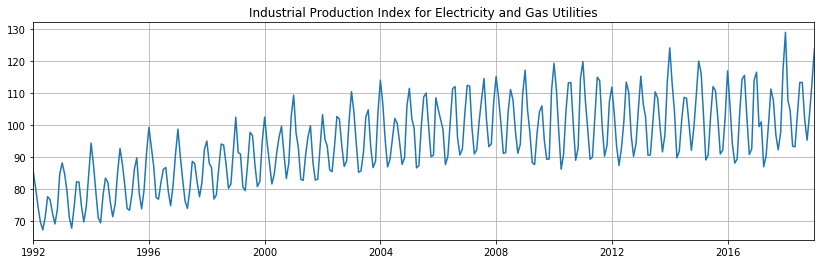

In [9]:
plt.figure(figsize=(14,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

## Prepare the data

To prepare the notebook, I devide the dataset into a tarin and a test set. I normalize the training set before defining LSTM model. Then I prepare windowed sequnece/label tuples for the model. 
For the first set of exercises we'll

### Divide the data into train and test sets
I divide the dataset into a sequence of 313 training records including the window, and a test set of 12 records. Accordingly, in this project, the size of the window will be 12. 

In [13]:
y = df['IPG2211A2N'].values.astype(float)
window_size, test_size = 12, 12
y_train = y[:-test_size]
y_test = y[-test_size:]
print(f'Train set size: {len(y_train)}')
print(f'Test set size:  {len(y_test)}')

Train set size: 313
Test set size:  12


### Normalize the training set to fit within the range [-1, 1]

In this part we normalize the data around zero to make hyperparameters converge faster. In order to do that, we use the formula:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the mean of the population, and $\sigma$ is standard deviation of the population.
We perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> to force our values fall between -1 and 1. The formula for min/max feature scaling is:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$ here.
We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'>sklearn.preprocessing.MinMaxScaler()</a>

We normalize the data using the mean and standard deviation of the training set to make sure there is no data leakage in our process. Otherwise, imagine if we consider test set during the normalization process, then the higher average values of the test set might be part of the signal in the training set according to <a href='test_set = input_data(test_norm,window_size)'>this article</a>.

We need to inverse_transform the predicted values to compare the values with the actual values of the test data after performing the predictions. 

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(y_train.reshape(-1, 1))

In [21]:
print(f'First 5 items (original): {y_train[0:5]}')
print(f'First 5 items (scaled):  {train_norm[0:5].reshape(1,5)}')

First 5 items (original): [85.556  80.4178 74.739  69.8367 67.3781]
First 5 items (scaled):  [[-0.4091274  -0.57614458 -0.76073396 -0.92008321 -1.        ]]


In [24]:
print(f'Minimum value for train set: {train_norm.min()}')
print(f'Maximum value for train set: {train_norm.max()}')
print(f'Average value for train set: {train_norm.mean()}')

Minimum value for train set: -1.0
Maximum value for train set: 1.0000000000000004
Average value for train set: -0.12206174942208882


### Data preprocessing for LSTM model
Firstly, I need to make the list of windowed sequence/label tuples as the input for the LSTM model.

In [26]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_function(seq, wsize=12):
    """
    Function to create seq/label tuples

    Arguments
    ---------
    seq (sequende): train data

    wsize    (int): window size
    
    """
    out_seq = []
    length = len(seq)
    for i in range(length - wsize):
        window = seq[i:i+wsize]
        label = seq[i+wsize:i+wsize+1]
        out_seq.append((window,label))
    return out_seq

In [27]:
train_data = input_function(train_norm)

In [34]:
print(f'Train_data size: {len(train_data)}')  # should be 301
print("\n\nFirst training sequence:")
train_data[0]

Train_data size: 301


First training sequence:


(tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
         -0.8313, -0.9396, -0.7939, -0.4343]), tensor([-0.3223]))

### Define LSTM model
In this part, I design a model that has a (1,100) LSTM layer and a (100,1) fully-connected linear layer.

In [35]:
class LSTMmodel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Adding an LSTM layer
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Adding a fully-connected layer
        self.linear = nn.Linear(hidden_size,output_size)
        
        # h0 and c0 initialization
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(out.view(len(seq),-1))
        return pred[-1]

In [36]:
torch.manual_seed(24)
model = LSTMmodel()
model

LSTMmodel(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [44]:
def count_parameters(model):
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    print(params)
    print(f' \nTotal number of the parameters in the model: {sum(params)}')
    
count_parameters(model)

[400, 40000, 400, 400, 100, 1]
 
Total number of the parameters in the model: 41301


### Loss and optimization functions
In this part, I define a loss function "criterion" and an optimizer.
Usually the preferred fuctions are MSELoss and Adam (learning rate of 0.001), respectively.

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training
Here, I use 60 epochs to train the model and I will evaluate it in the next step.

In [55]:
epochs = 60
for i in range(epochs):
    for seq, y in train_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)

        # update the parameters
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    if i%5 == 0:
        print(f'{i+1} of {epochs} epochs done!')

1 of 60 epochs done!
6 of 60 epochs done!
11 of 60 epochs done!
16 of 60 epochs done!
21 of 60 epochs done!
26 of 60 epochs done!
31 of 60 epochs done!
36 of 60 epochs done!
41 of 60 epochs done!
46 of 60 epochs done!
51 of 60 epochs done!
56 of 60 epochs done!


### Evaluate the model based on the test set

In [56]:
# re-initialize the hidden parameters h0 and c0 before running the model
pred_size = 12
preds = train_norm[-window_size:].tolist()
model.eval()

for i in range(pred_size):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
preds[window_size:]

[0.6177246570587158,
 0.26985281705856323,
 -0.30596446990966797,
 -0.21524521708488464,
 0.16543693840503693,
 0.3707064390182495,
 0.24127809703350067,
 -0.0033061024732887745,
 -0.24428226053714752,
 -0.07204584777355194,
 0.2988438606262207,
 0.6243056058883667]

Then, we need to rescale the predicted values up to the original to get the original values according to test set range.

In [57]:
true_pred = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_pred

array([[117.14659021],
       [106.44448699],
       [ 88.72975607],
       [ 91.52068852],
       [103.23218469],
       [109.54719824],
       [105.56540002],
       [ 98.04088941],
       [ 90.6273784 ],
       [ 95.92614552],
       [107.33638195],
       [117.34904981]])

To get a better view of the predictions, I plot the predictions values along with the original data.

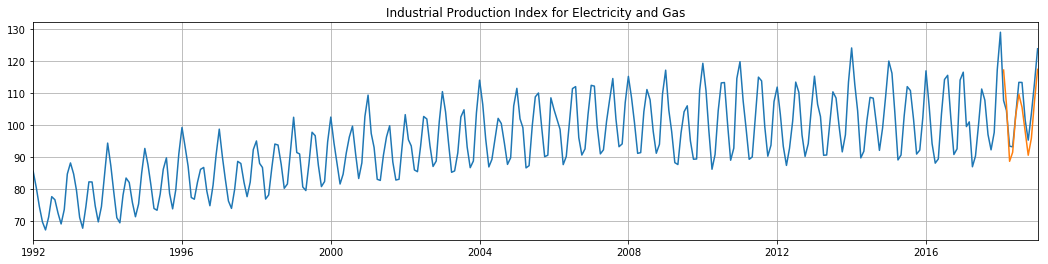

In [58]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(18,4))
plt.title('Industrial Production Index for Electricity and Gas')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_pred)
plt.show()

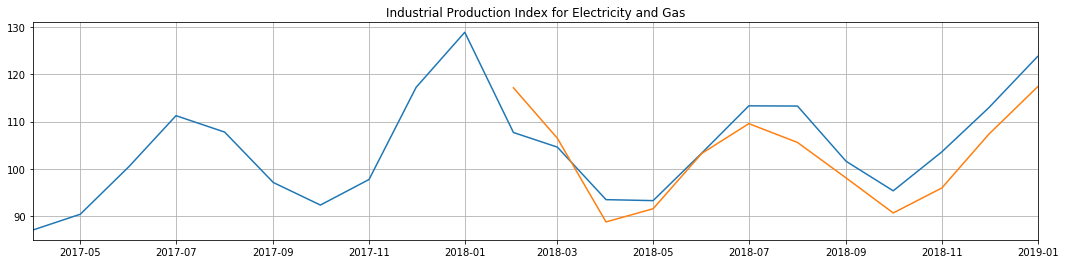

In [59]:
# Zoom in at the prediction
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(18,4))
plt.title('Industrial Production Index for Electricity and Gas')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N']['2017-04-01':])
plt.plot(x,true_pred)
plt.show()

According to the plots, my prediction results are very close to the true values of y for the test set to show the seasonalities. 